In [ ]:
import pandas as pd
import numpy as np
import quantstats as qs
import warnings
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UserWarning) # Quantstats might issue user warnings


# --- Function Definitions ---

# Step 1: Load Data (Mostly unchanged)
def load_data(cb_path, index_path):
    """Loads CB and index data, ensures DatetimeIndex."""
    print("--- Step 1: Loading Data ---")
    try:
        df = pd.read_parquet(cb_path)
        index_df = pd.read_parquet(index_path)
        # Ensure index_df has DatetimeIndex
        if not isinstance(index_df.index, pd.DatetimeIndex):
            index_df.index = pd.to_datetime(index_df.index)
        # Ensure df has correct MultiIndex with DatetimeIndex for trade_date
        required_levels = ['code', 'trade_date']
        if all(level in df.index.names for level in required_levels):
            date_level_idx = df.index.names.index('trade_date')
            if not isinstance(df.index.levels[date_level_idx], pd.DatetimeIndex):
                 df.index = df.index.set_levels(pd.to_datetime(df.index.levels[date_level_idx]), level='trade_date')
        else: # Try setting index if columns exist
            if all(col in df.columns for col in required_levels):
                 df['trade_date'] = pd.to_datetime(df['trade_date'])
                 df = df.set_index(required_levels)
            else: raise ValueError("CB data missing 'code' or 'trade_date' for index.")
        print(f"Loaded CB data shape: {df.shape}, Index data shape: {index_df.shape}")
        return df, index_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Step 2: Filter Data (Mostly unchanged)
def filter_data(df, start_date, end_date, filter_rules, factors_needed):
    """Applies date range and custom filters."""
    print("--- Step 2: Filtering Data ---")
    if df is None: return None

    # Check if factor columns exist BEFORE filtering
    missing_factors = [f for f in factors_needed if f not in df.columns]
    if missing_factors:
        print(f"Error: Required factor columns missing from data: {missing_factors}")
        return None

    # Date filtering
    try:
        # Ensure 'trade_date' is in the index before trying to get level values
        if 'trade_date' not in df.index.names:
             raise KeyError("'trade_date' not found in DataFrame index levels.")
        trade_date_level = df.index.get_level_values('trade_date')
        date_mask = (trade_date_level >= start_date) & (trade_date_level <= end_date)
        df_filtered = df[date_mask].copy()
        if df_filtered.empty: raise ValueError("No data remaining after date filtering.")
        print(f"Filtered by date: {start_date} to {end_date}. Shape: {df_filtered.shape}")
    except Exception as e:
        print(f"Error during date filtering: {e}")
        return None

    # Apply filters
    df_filtered['filter_out'] = False
    # Apply essential filters not in rules (if any) - uncomment/add as needed
    # print("Applying essential filters...")
    redeem_statuses = ['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']
    if 'is_call' in df_filtered.columns: df_filtered.loc[df_filtered['is_call'].isin(redeem_statuses), 'filter_out'] = True
    if 'list_days' in df_filtered.columns: df_filtered.loc[df_filtered['list_days'] <= 3, 'filter_out'] = True

    print("Applying custom filters...")
    for rule in filter_rules:
        try:
            print(f" - Applying: {rule}")
            matching_indices = df_filtered.query(rule).index
            df_filtered.loc[matching_indices, 'filter_out'] = True
        except Exception as e:
            print(f"  - Warning: Could not apply filter rule '{rule}'. Error: {e}")

    # Also filter out rows where any needed factor is NaN
    print("Filtering rows with NaN in factor values...")
    nan_mask = df_filtered[factors_needed].isna().any(axis=1)
    df_filtered.loc[nan_mask, 'filter_out'] = True

    eligible_count = len(df_filtered[~df_filtered['filter_out']])
    print(f"Filtering complete. Eligible bond-days: {eligible_count}")
    if eligible_count == 0:
        print("Warning: No bonds eligible after applying all filters.")
        # Don't return None yet, let subsequent steps handle empty eligible set if needed
    return df_filtered




# --- Revised Rank-Based Scoring Function (Use this one) ---
def calculate_weighted_score(df, factor_weights):
    """
    Ranks factors based on weight direction and calculates a weighted final score based on ranks.
    Lower rank numbers are considered better. Robust index handling.
    """
    print("--- Step 3: Calculating Weighted Score (Rank-Based) ---")
    # ... (Initial checks for df, index, filter_out column - same as before) ...
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: Input DataFrame index is not MultiIndex('code', 'trade_date'). Index: {df.index}")
         return None

    df_scored = df.copy()
    df_scored['final_score'] = 0.0
    df_eligible = df_scored[~df_scored['filter_out']]

    if df_eligible.empty:
        print("Warning: No eligible bonds to score.")
        df_scored['final_score'] = np.nan
        for factor in factor_weights.keys(): df_scored[f"{factor}_rank"] = np.nan
        return df_scored

    if not isinstance(df_eligible.index, pd.MultiIndex) or 'trade_date' not in df_eligible.index.names:
         print(f"Error: df_eligible index lost structure before ranking. Index: {df_eligible.index}")
         return None

    print("Calculating ranks and weighted score...")
    rank_data = {} # Store eligible ranks Series

    # --- Part 1: Calculate Ranks ---
    for factor, weight in factor_weights.items():
        if factor not in df_scored.columns:
            print(f"Warning: Factor '{factor}' not found. Skipping.")
            df_scored[f"{factor}_rank"] = np.nan
            continue
        if weight == 0:
             df_scored[f"{factor}_rank"] = np.nan
             continue

        ascending_rank = (weight < 0)
        print(f" - Ranking '{factor}': weight={weight}, ascending_rank={ascending_rank}")
        try:
            ranks = df_eligible.groupby(level='trade_date')[factor].rank(method='first', ascending=ascending_rank)
            rank_data[factor] = ranks
            df_scored[f"{factor}_rank"] = ranks
        except Exception as e:
            print(f"Error ranking factor '{factor}': {e}")
            df_scored[f"{factor}_rank"] = np.nan


    # --- Part 2: Combine Ranks into Final Score (Revised fillna) ---
    print("\nCombining ranks into final score...")

    # Calculate daily eligible counts ONCE
    try:
        if 'trade_date' not in df_eligible.index.names: raise ValueError("'trade_date' not in df_eligible index names for counts.")
        daily_eligible_counts = df_eligible.groupby(level='trade_date').size()
    except Exception as e:
        print(f"Error calculating daily counts: {e}")
        return None

    # Initialize final score Series aligned with df_eligible
    final_score_eligible = pd.Series(0.0, index=df_eligible.index)

    for factor, weight in factor_weights.items():
        if factor not in rank_data: continue # Skip if no ranks were calculated

        abs_weight = abs(weight)
        if abs_weight > 0:
             print(f" - Combining ranks for '{factor}' (weight: {abs_weight:.2f})")
             current_ranks = rank_data[factor] # Series with eligible ranks only

             # --- Simpler fillna using direct mapping ---
             # Create the map from date to count
             fill_map_dict = daily_eligible_counts.to_dict()
             # Get the date level from the ranks index
             rank_dates = current_ranks.index.get_level_values('trade_date')
             # Create the fill values Series by mapping dates to counts
             # Use a default large value if a date is somehow missing from the map
             fill_values = rank_dates.map(fill_map_dict).fillna(len(df_eligible)) # Get fill values

             # Ensure fill_values is a Series aligned with current_ranks
             fill_values_series = pd.Series(fill_values, index=current_ranks.index) # Create Series

             # Fill NaNs in current_ranks using the aligned fill_values_series
             # Now the 'value' passed to fillna is guaranteed to be a Series
             ranks_filled = current_ranks.fillna(value=fill_values_series) # Pass Series to value
             # --- End Simpler fillna ---


             # Check for remaining NaNs (optional)
             # if ranks_filled.isna().any():
             #     print(f"  -> Warning: NaNs still remain after fillna for factor {factor}. This is unexpected.")
             #     ranks_filled = ranks_filled.fillna(len(df_eligible))

             final_score_eligible += ranks_filled * abs_weight

    # Assign the calculated scores back
    df_scored['final_score'] = final_score_eligible
    df_scored.loc[df_scored['filter_out'], 'final_score'] = np.nan

    print("Score calculation complete.")
    return df_scored


# Step 4: Assign Quantile Bins
def assign_quantile_bins(df, score_column, num_bins):
    """Assigns quantile bins based on the score column for each day."""
    print(f"--- Step 4: Assigning {num_bins} Quantile Bins based on '{score_column}' ---")
    if df is None or score_column not in df.columns: return None
    # Ensure index is the expected MultiIndex
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for binning. Index: {df.index}")
         return None

    df_binned = df.copy()
    df_binned['quantile_bin'] = pd.NA # Initialize with pandas NA

    eligible_scored_rows = ~df_binned['filter_out'] & ~df_binned[score_column].isna()
    if not eligible_scored_rows.any():
         print("Warning: No rows with valid scores found to assign bins.")
         return df_binned

    # --- Inside assign_quantile_bins function ---
    def qcut_safe(x, q, labels):
        # x is the Series of scores for a single day
        if x.nunique() < 2 or len(x) < q: # Check minimum conditions
            return pd.Series([pd.NA] * len(x), index=x.index)
        try:
            # --- CHANGE 'rank' to 'drop' ---
            return pd.qcut(x, q=q, labels=labels, duplicates='drop')
            # --- End Change ---
        except Exception as e:
            print(f"Warning: qcut failed on day ... Error: {e}. Assigning NA.") # Simplified warning
            return pd.Series([pd.NA] * len(x), index=x.index)
    # --- End modification ---

    # Group by 'trade_date' level before applying transform
    if 'trade_date' not in df_binned.index.names:
         print("Error: Cannot assign bins, 'trade_date' not in index.")
         return None

    # Apply qcut within each group only to eligible rows with scores
    bins = df_binned.loc[eligible_scored_rows].groupby(level='trade_date')[score_column].transform(
        lambda x: qcut_safe(x, q=num_bins, labels=False) # labels=False gives 0, 1, 2...
    )

    df_binned['quantile_bin'] = bins # Assign calculated bins back (will have NA where failed/ineligible)

    # Convert bin number to integer, keeping NAs
    df_binned['quantile_bin'] = df_binned['quantile_bin'].astype('Int64')

    binned_count = df_binned['quantile_bin'].notna().sum()
    total_eligible_scored = eligible_scored_rows.sum()
    print(f"Assigned bins to {binned_count} out of {total_eligible_scored} eligible scored bond-days.")
    if binned_count < total_eligible_scored:
         print(f"Warning: Failed to assign bins for {total_eligible_scored - binned_count} bond-days (likely due to insufficient unique scores/items on some days).")
    if binned_count == 0 and total_eligible_scored > 0:
         print("CRITICAL Warning: Failed to assign any bonds to bins despite having eligible scored rows.")


    return df_binned


# Step 5: Calculate Bin Performance
def calculate_bin_performance(df_binned, num_bins, sp_pct, commission_rate):
    """Calculates daily returns for each quantile bin."""
    print("--- Step 5: Calculating Performance for Each Bin ---")
    if df_binned is None or 'quantile_bin' not in df_binned.columns: return None
    # Ensure index is the expected MultiIndex
    if not isinstance(df_binned.index, pd.MultiIndex) or not all(name in df_binned.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for performance calc. Index: {df_binned.index}")
         return None


    df_perf = df_binned.dropna(subset=['quantile_bin']).copy() # Only rows assigned to a bin
    if df_perf.empty:
        print("Warning: No bonds with valid bins found for performance calculation.")
        return pd.DataFrame() # Return empty DataFrame

    print("Calculating next-day returns and applying stop-profit...")
    # --- Ensure grouping by 'code' level ---
    if 'code' not in df_perf.index.names:
         raise ValueError("'code' level not found in index for grouping in performance calc.")
    grouped = df_perf.groupby(level='code')
    # --- End Grouping Check ---
    df_perf['aft_open'] = grouped['open'].shift(-1)
    df_perf['aft_close'] = grouped['close'].shift(-1)
    df_perf['aft_high'] = grouped['high'].shift(-1)
    df_perf['time_return'] = grouped['pct_chg'].shift(-1)

    sp_triggered_high = (df_perf['aft_high'] >= df_perf['close'] * (1 + sp_pct))
    sp_triggered_open = (df_perf['aft_open'] >= df_perf['close'] * (1 + sp_pct))
    df_perf.loc[sp_triggered_open, 'time_return'] = (df_perf['aft_open'] - df_perf['close']) / df_perf['close']
    df_perf.loc[sp_triggered_high & ~sp_triggered_open, 'time_return'] = sp_pct

    df_perf.dropna(subset=['time_return'], inplace=True)
    if df_perf.empty:
         print("Warning: No valid next-day returns found after stop-profit calculation.")
         return pd.DataFrame()

    print("Calculating raw daily returns per bin...")
    # --- Ensure grouping by 'trade_date', 'quantile_bin' ---
    if 'trade_date' not in df_perf.index.names:
         raise ValueError("'trade_date' level not found in index for grouping returns.")
    raw_bin_returns = df_perf.groupby(['trade_date', 'quantile_bin'])['time_return'].mean()
    # --- End Grouping Check ---
    raw_bin_returns_unstacked = raw_bin_returns.unstack(level='quantile_bin')

    print("Calculating approximate transaction costs per bin...")
    bin_costs = {}
    all_bin_signals = {}

    # --- Use df_binned (with NAs in quantile_bin) for cost calculation ---
    # It contains the full universe needed for accurate turnover signal diffs
    print("Calculating approximate transaction costs per bin...")
    bin_costs = {}
    all_bin_signals = {} # Store signals for each bin

    # --- Use df_binned (with NAs in quantile_bin) for cost calculation ---
    for i in range(num_bins):
        signal_col_name = f'signal_bin_{i}'
        # Ensure 'quantile_bin' exists before comparison
        if 'quantile_bin' not in df_binned.columns:
             print(f"Error: 'quantile_bin' column missing for cost calculation of bin {i}")
             continue

        # *** FIX: Handle pd.NA before comparison ***
        # Create the boolean condition by first filling NA with an impossible bin number (e.g., -1)
        condition = (df_binned['quantile_bin'].fillna(-1) == i)
        # *** End FIX ***

        # Now use the clean boolean 'condition' in np.where
        df_binned[signal_col_name] = np.where(condition, 1, 0)

        all_bin_signals[i] = df_binned[signal_col_name] # Store the 0/1 signal

        # --- Check index before unstack ---
        # ... (rest of the cost calculation logic remains the same) ...
        if not isinstance(df_binned.index, pd.MultiIndex) or not all(name in df_binned.index.names for name in ['code', 'trade_date']):
              print(f"Error: Invalid index for unstacking in cost calculation for bin {i}. Index: {df_binned.index}")
              bin_costs[i] = pd.Series(0.0, index=raw_bin_returns_unstacked.index if 'raw_bin_returns_unstacked' in locals() else None).fillna(0) # Assign zero cost as fallback
              continue
        try:
            pos_df = df_binned[signal_col_name].unstack(level='code', fill_value=0).astype(int)
            pos_df.index = pd.to_datetime(pos_df.index) # Ensure index is datetime

            turnover = pos_df.diff().fillna(0).abs().sum(axis=1)
            prev_positions = pos_df.shift(1).sum(axis=1)
            curr_positions = pos_df.sum(axis=1)
            total_exposure_factor = (prev_positions + curr_positions).replace(0, np.nan)

            daily_cost_pct = (turnover * commission_rate) / total_exposure_factor
            daily_cost_pct = daily_cost_pct.reindex(pos_df.index).fillna(0) # Align and fill zero
            if not daily_cost_pct.empty and len(pos_df) > 0: # Check pos_df length too
                daily_cost_pct.iloc[0] = 0.5 * commission_rate if curr_positions.iloc[0] > 0 else 0

            bin_costs[i] = daily_cost_pct

        except Exception as cost_e:
            print(f"Error calculating cost for bin {i}: {cost_e}")
            bin_costs[i] = pd.Series(0.0, index=raw_bin_returns_unstacked.index if 'raw_bin_returns_unstacked' in locals() else None).fillna(0)


    print("Calculating net returns per bin...")
    net_bin_returns = {}
    valid_bins = raw_bin_returns_unstacked.columns
    print(f"Bins with calculated raw returns: {valid_bins.tolist()}")

    for i in range(num_bins):
        if i not in valid_bins:
             print(f"Skipping bin {i} (no raw returns).")
             continue # Skip if a bin had no returns

        bin_ret = raw_bin_returns_unstacked[i].fillna(0)

        # Ensure bin_costs[i] exists and align its index
        if i in bin_costs:
             bin_cst = bin_costs[i].reindex(bin_ret.index).fillna(0)
        else:
             print(f"Warning: Costs not calculated for bin {i}. Assuming zero cost.")
             bin_cst = pd.Series(0.0, index=bin_ret.index)


        net_ret = (1 + bin_ret) * (1 - bin_cst) - 1
        net_bin_returns[f'Bin_{i}'] = net_ret

    net_returns_df = pd.DataFrame(net_bin_returns)
    print("Performance calculation complete.")
    return net_returns_df


# Step 6: Analyze Factor Correlation
def analyze_factor_correlation(df, factors):
    """Calculates and displays the correlation matrix for the selected factors."""
    print("--- Step 6: Analyzing Factor Correlation ---")
    if df is None or 'filter_out' not in df.columns: return None
    if not isinstance(df.index, pd.MultiIndex) or not all(name in df.index.names for name in ['code', 'trade_date']):
         print(f"Error: DataFrame index is not the expected MultiIndex for correlation. Index: {df.index}")
         return None


    df_eligible = df[~df['filter_out']].copy()
    if df_eligible.empty: print("Warning: No eligible bonds for correlation."); return None
    if len(df_eligible) < 2: print("Warning: Less than 2 data points for correlation."); return None

    missing_factors = [f for f in factors if f not in df_eligible.columns]
    if missing_factors: print(f"Warning: Factors missing for correlation: {missing_factors}"); return None
    present_factors = [f for f in factors if f in df_eligible.columns]
    if len(present_factors) < 2: print("Warning: Need at least 2 factors for correlation."); return None

    factor_data = df_eligible[present_factors]
    factor_data = factor_data.replace([np.inf, -np.inf], np.nan)
    factor_data.dropna(inplace=True) # Drop rows with NaNs in ANY factor column being correlated

    if len(factor_data) < 2: print("Warning: Less than 2 valid data points after NaN drop for correlation."); return None

    print("Calculating Spearman rank correlation matrix...")
    try:
        correlation_matrix = factor_data.corr(method='spearman')
        print("Factor Correlation Matrix:")
        plt.figure(figsize=(max(6, len(present_factors)), max(5, len(present_factors)-1))) # Adjust size
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Factor Spearman Rank Correlation Heatmap')
        plt.show()
        return correlation_matrix
    except Exception as corr_e:
         print(f"Error calculating or plotting correlation: {corr_e}")
         return None


# --- Main Execution Function ---
def run_factor_binning_analysis(config):
    """Orchestrates the factor analysis workflow."""

    # Step 1: Load Data
    df_cb_raw, df_index = load_data(config['cb_data_path'], config['index_data_path'])
    if df_cb_raw is None: return None

    # Step 2: Filter Data
    factors_to_analyze = list(config['factors_and_weights'].keys())
    df_filtered = filter_data(df_cb_raw, config['start_date'], config['end_date'],
                              config['filters'], factors_to_analyze)
    if df_filtered is None or len(df_filtered[~df_filtered['filter_out']]) == 0:
        print("Stopping analysis due to filtering issues or no eligible data.")
        return None

    # --- DIAGNOSTIC CHECK (as requested before) ---
    try:
        eligible_counts_daily = df_filtered[~df_filtered['filter_out']].groupby(level='trade_date').size()
        print("\n--- Post-Filter Daily Eligible Bond Counts ---")
        if not eligible_counts_daily.empty:
            print(f"Min eligible bonds on any day: {eligible_counts_daily.min()}")
            print(f"Max eligible bonds on any day: {eligible_counts_daily.max()}")
            num_bins_config = config.get('num_bins', 5)
            days_below_bins = (eligible_counts_daily < num_bins_config).sum()
            total_days = len(eligible_counts_daily)
            print(f"Number of days with < {num_bins_config} eligible bonds: {days_below_bins} out of {total_days} days ({days_below_bins/total_days:.1%})")
        else:
            print("No eligible bonds found on any day according to counts.")
    except Exception as diag_e: print(f"Error during diagnostic check: {diag_e}")
    # --- END DIAGNOSTIC CHECK ---


    # Step 3: Calculate Score
    df_scored = calculate_weighted_score(df_filtered, config['factors_and_weights'])
    if df_scored is None: print("Stopping: Score calculation failed."); return None

    # --- Add this AFTER Step 3 in run_factor_binning_analysis ---
    if 'df_scored' in locals() and df_scored is not None and 'final_score' in df_scored.columns:
        print("\n--- Analyzing Final Score Distribution ---")
        eligible_scores = df_scored[~df_scored['filter_out']]['final_score'].dropna()

        if not eligible_scores.empty:
            # Pick a sample date (e.g., the first one with eligible scores)
            sample_date = eligible_scores.index.get_level_values('trade_date').min()
            scores_on_sample_date = eligible_scores.loc[(slice(None), sample_date)]

            print(f"Analyzing scores for sample date: {sample_date}")
            print(f"Number of eligible scores on this date: {len(scores_on_sample_date)}")
            print(f"Number of UNIQUE scores on this date: {scores_on_sample_date.nunique()}")
            print(f"Score value counts (top 10):\n{scores_on_sample_date.value_counts().head(10)}")

            # Plot histogram
            try:
                import matplotlib.pyplot as plt
                plt.figure(figsize=(10, 4))
                scores_on_sample_date.hist(bins=50) # Use more bins to see detail
                plt.title(f'Histogram of Final Scores on {sample_date}')
                plt.xlabel('Final Score')
                plt.ylabel('Frequency')
                plt.show()
            except Exception as plot_e:
                print(f"Could not plot histogram: {plot_e}")

        else:
            print("No valid final scores found to analyze distribution.")
    else:
        print("df_scored or final_score column not available for distribution analysis.")
    # --- End of score distribution analysis block ---

    # Step 4: Assign Bins
    df_binned = assign_quantile_bins(df_scored, 'final_score', config['num_bins'])
    if df_binned is None or df_binned['quantile_bin'].isna().all():
         print("Stopping analysis - failed to assign bins.")
         return None

    # Step 5: Calculate Bin Performance
    bin_returns_df = calculate_bin_performance(df_binned, config['num_bins'],
                                             config['stop_profit_pct'], config['commission_rate'])
    if not isinstance(bin_returns_df, pd.DataFrame) or bin_returns_df.empty:
        print("Stopping analysis - failed to calculate bin performance.")
        return None

    # Step 6: Analyze Factor Correlation
    correlation_matrix = analyze_factor_correlation(df_filtered, factors_to_analyze) # Use df_filtered

    # --- Step 7: Report Results ---
    print("\n--- Factor Analysis Results ---")
    # benchmark_returns = None
    # if df_index is not None and config['benchmark_col'] in df_index.columns:
    #     benchmark_daily = df_index[config['benchmark_col']].pct_change().fillna(0)
    #     benchmark_returns = benchmark_daily.reindex(bin_returns_df.index).fillna(0)
    #     benchmark_returns.name = config['benchmark_col']
    #     print(f"Using benchmark: {config['benchmark_col']}")
    # else: print("Benchmark not available or not found.")

    all_metrics = {}
    print("\nPerformance Metrics per Bin:")
    if not bin_returns_df.empty:
        for bin_col in bin_returns_df.columns:
            print(f"\n--- Metrics for {bin_col} ---")
            try:
                # Ensure column exists before accessing
                if bin_col in bin_returns_df:
                     metrics_df = qs.reports.metrics(bin_returns_df[bin_col], benchmark=df_index[CONFIG['benchmark_col']], display=True)
                     all_metrics[bin_col] = metrics_df
                else:
                     print(f"Column {bin_col} not found in bin returns.")
            except Exception as metrics_e:
                 print(f"Error calculating metrics for {bin_col}: {metrics_e}")

        print("\nPlotting Cumulative Returns per Bin...")
        try:
            qs.plots.cumulative_returns(bin_returns_df, benchmark=df_index[CONFIG['benchmark_col']],
                                        title=f"Cumulative Returns by Factor Score Quantile ({config['num_bins']} Bins)")
            plt.show()
        except Exception as e: print(f"Could not generate cumulative return plot: {e}")

        top_bin_col = f'Bin_{config["num_bins"]-1}'
        bottom_bin_col = 'Bin_0'
        if top_bin_col in bin_returns_df.columns and bottom_bin_col in bin_returns_df.columns:
             top_bin = bin_returns_df[top_bin_col]
             bottom_bin = bin_returns_df[bottom_bin_col]
             spread = top_bin - bottom_bin
             print("\n--- Metrics for Top Bin - Bottom Bin Spread ---")
             try:
                 qs.reports.metrics(spread, mode='full', display=True)
                 print("\nPlotting Top-Bottom Spread Cumulative Return...")
                 qs.plots.cumulative_returns(spread, benchmark=None, title="Top Bin - Bottom Bin Spread")
                 plt.show()
             except Exception as spread_e:
                  print(f"Error analyzing spread: {spread_e}")
        else:
             print("\nCould not calculate spread (Top or Bottom bin missing).")
    else:
         print("Bin returns DataFrame is empty, skipping metrics and plots.")


    print("\n--- Factor Correlation Matrix ---")
    if correlation_matrix is not None: display(correlation_matrix)
    else: print("Correlation matrix could not be calculated.")

    print("\n--- Analysis Complete ---")
    return {
        "bin_returns": bin_returns_df,
        "bin_metrics": all_metrics,
        "factor_correlation": correlation_matrix
    }



--- Step 1: Loading Data ---
Loaded CB data shape: (591271, 78), Index data shape: (1760, 8)
--- Step 2: Filtering Data ---
Filtered by date: 20220801 to 20240101. Shape: (168627, 78)
Applying custom filters...
 - Applying: close < 102
 - Applying: close > 180
 - Applying: left_years < 0.5
 - Applying: amount < 500
Filtering rows with NaN in factor values...
Filtering complete. Eligible bond-days: 130802

--- Post-Filter Daily Eligible Bond Counts ---
Min eligible bonds on any day: 298
Max eligible bonds on any day: 468
Number of days with < 5 eligible bonds: 0 out of 346 days (0.0%)
--- Step 3: Calculating Weighted Score (Rank-Based) ---
Calculating ranks and weighted score...
 - Ranking 'ytm': weight=1.0, ascending_rank=False
 - Ranking 'conv_prem': weight=-1.0, ascending_rank=True
 - Ranking 'turnover_5': weight=0.5, ascending_rank=False
 - Ranking 'bond_prem': weight=-1.0, ascending_rank=True

Combining ranks into final score...
 - Combining ranks for 'ytm' (weight: 1.00)
 - Combin

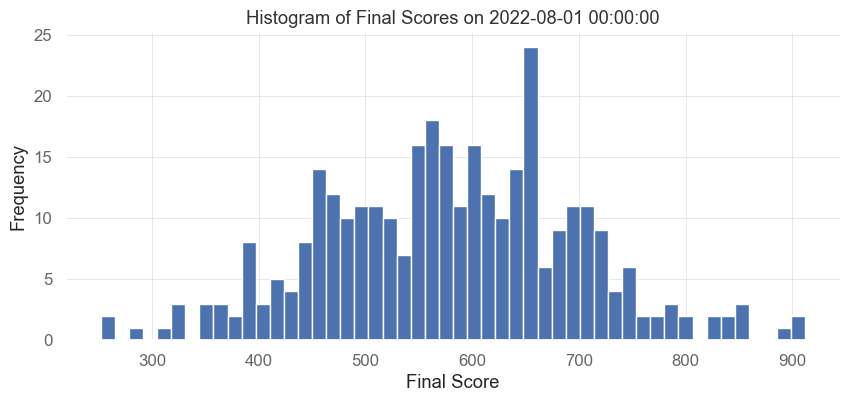

--- Step 4: Assigning 5 Quantile Bins based on 'final_score' ---
Assigned bins to 130802 out of 130802 eligible scored bond-days.
--- Step 5: Calculating Performance for Each Bin ---
Calculating next-day returns and applying stop-profit...
Calculating raw daily returns per bin...
Calculating approximate transaction costs per bin...
Calculating approximate transaction costs per bin...
Calculating net returns per bin...
Bins with calculated raw returns: [0, 1, 2, 3, 4]
Performance calculation complete.
--- Step 6: Analyzing Factor Correlation ---
Calculating Spearman rank correlation matrix...
Factor Correlation Matrix:


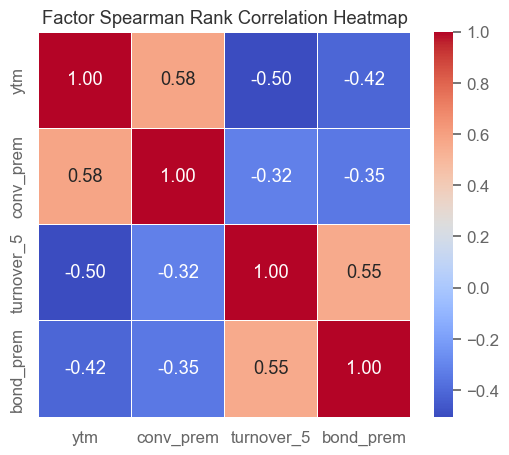


--- Factor Analysis Results ---

Performance Metrics per Bin:

--- Metrics for Bin_0 ---
                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2022-08-01   2022-08-01
End Period          2023-12-28   2023-12-28
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   -9.4%        19.47%
CAGR﹪              -4.72%       9.11%

Sharpe              -0.71        1.93
Prob. Sharpe Ratio  20.24%       98.83%
Sortino             -0.95        3.06
Sortino/√2          -0.67        2.17
Omega               1.37         1.37

Max Drawdown        -12.81%      -4.53%
Longest DD Days     498          85

Gain/Pain Ratio     -0.11        0.37
Gain/Pain (1M)      -0.4         4.55

Payoff Ratio        1.01         1.08
Profit Factor       0.89         1.37
Common Sense Ratio  0.85         1.64
CPC Index           0.43         0.8
Tail Ratio          0.95         1.19
Outlier Win Ratio   2.64         3.34
Outl

,ytm,conv_prem,turnover_5,bond_prem
ytm,1.000000,0.578351,-0.504003,-0.415337
conv_prem,0.578351,1.000000,-0.317629,-0.346561
turnover_5,-0.504003,-0.317629,1.000000,0.554429
bond_prem,-0.415337,-0.346561,0.554429,1.000000



--- Analysis Complete ---


In [2]:
# --- Configuration ---
CONFIG = {
    # File Paths
    'cb_data_path': '/Users/yiwei/Desktop/git/cb_data_with_factors2.pq', # CHANGE TO YOUR PATH
    'index_data_path': '/Users/yiwei/Desktop/git/index.pq', # CHANGE TO YOUR PATH

    # Analysis Settings
    'start_date': '20220801',
    'end_date': '20240101',   # Adjust end date as needed
    'num_bins': 5,           # Number of quantiles (e.g., 5 for quintiles)
    'benchmark_col': 'index_jsl',

    # Stop-Profit & Commission (for return calculation)
    'stop_profit_pct': 0.03,
    'commission_rate': 2 / 1000,

    # Data Filtering Rules (applied first)
    'filters': [
        "close < 102",
        "close > 155", # Example: wider price range for analysis
        "left_years < 0.5",
        "amount < 500",  # Example: lower liquidity threshold
        # Add other essential filters if needed (like redeem status, list_days)
        "is_call.isin(['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']) == False", # Example keeping only non-redeem
        # "list_days > 3"
    ],

    # Factors to Analyze and their Weights for the Composite Score
    # Keys: Factor column names from df.
    # Values: Weight (positive means higher factor value -> better score contribution,
    #         negative means lower factor value -> better score contribution).
    # The ranking logic internally handles this direction based on weight sign.
    'factors_and_weights': {
        'ytm': 1.0,           # Higher YTM is better
        'conv_prem': -1.0,    # Lower premium is better
        'turnover_5': 1.5,    # Higher turnover might indicate interest
        'bond_prem': -1.0,    # Lower bond premium (closer to pure bond value) might be safer
        'theory_bias': -1,
        # Add other factors you want to combine
    }
}

analysis_results = run_factor_binning_analysis(CONFIG)